In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
# % get_backend()
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split

from feat_to_model_eval import feat_to_model_kfold_eval, predict_from_line
from haversine import distance_from_flatiron

In [63]:
df = pd.read_csv('kc_house_data.csv')

# CRISP - DM

## Data Understanding

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [65]:
"""id and date act as names, sqft_basement does not apply to all dwellings, sqft_lot and sqft_lot15 do not correspond exactly to the dwelling. lat and long will be used in another feature."""
df = df.drop(['id', 'date', 'sqft_basement', "sqft_above", 'lat', 'long', 'sqft_lot', 'sqft_lot15'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15
0,221900.0,3,1.00,1180,1.0,NaN,0.0,3,7,1955,0.0,98178,1340
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,1951,1991.0,98125,1690
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,1933,NaN,98028,2720
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1965,0.0,98136,1360
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1987,0.0,98074,1800


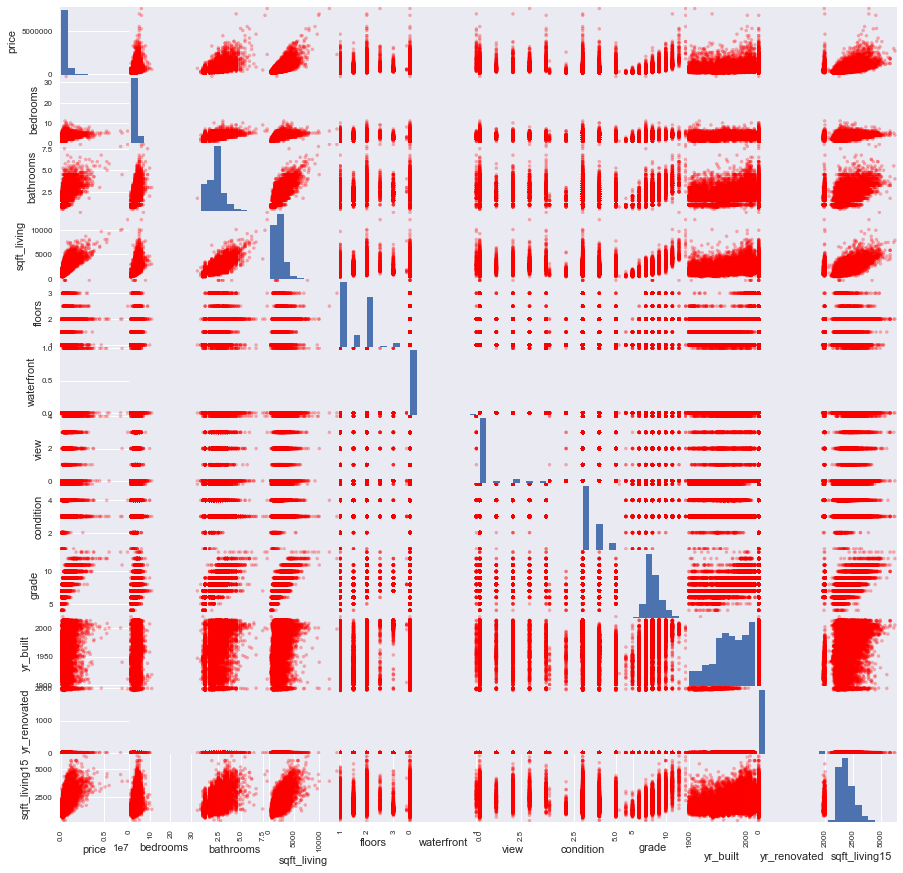

In [39]:
pd.plotting.scatter_matrix(df, figsize=(15,15), c = "red", alpha=0.3)
plt.show()

In [66]:
df.corr().price

price            1.000000
bedrooms         0.308787
bathrooms        0.525906
sqft_living      0.701917
floors           0.256804
waterfront       0.276295
view             0.395734
condition        0.036056
grade            0.667951
yr_built         0.053953
yr_renovated     0.129599
zipcode         -0.053402
sqft_living15    0.585241
Name: price, dtype: float64

In [67]:
"""Here are the strongest candidates; correlation over 0.5 """
temp = df[['price', 'sqft_living', 'sqft_living15', 'bathrooms', 'grade']]
temp.corr().price[1:]

sqft_living      0.701917
sqft_living15    0.585241
bathrooms        0.525906
grade            0.667951
Name: price, dtype: float64

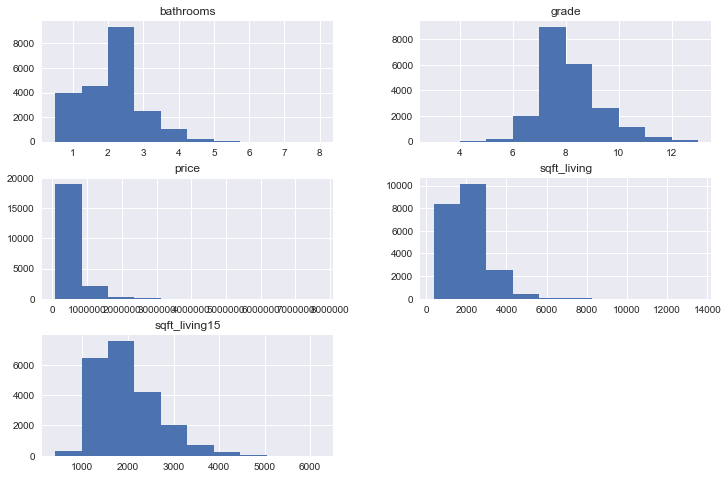

In [53]:
temp.hist(figsize=(12,8))
plt.show()

In [68]:
"""These parameters don't meet the assumptions for linear regression, so we'll scale some with log."""
log_df = pd.DataFrame([])
for col in temp:
    log_df[f'log_{col}'] = np.log(temp[col])
log_df.head()

,log_price,log_sqft_living,log_sqft_living15,log_bathrooms,log_grade
0,12.309982,7.073270,7.200425,0.000000,1.945910
1,13.195614,7.851661,7.432484,0.810930,1.945910
2,12.100712,6.646391,7.908387,0.000000,1.791759
3,13.311329,7.580700,7.215240,1.098612,1.945910
4,13.142166,7.426549,7.495542,0.693147,2.079442


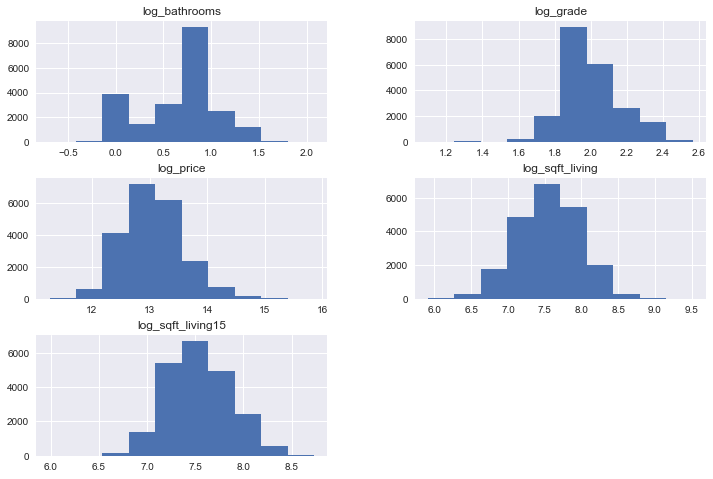

In [69]:
"""All of these distributions have improved with by taking the log, except bathrooms. This is likely because there are entries with bathrooms < 1; making their logs negative."""
log_df.hist(figsize = (12,8))
plt.show()

In [70]:
log_df.drop(['log_bathrooms'], axis = 1, inplace = True)
log_df.head()

,log_price,log_sqft_living,log_sqft_living15,log_grade
0,12.309982,7.073270,7.200425,1.945910
1,13.195614,7.851661,7.432484,1.945910
2,12.100712,6.646391,7.908387,1.791759
3,13.311329,7.580700,7.215240,1.945910
4,13.142166,7.426549,7.495542,2.079442


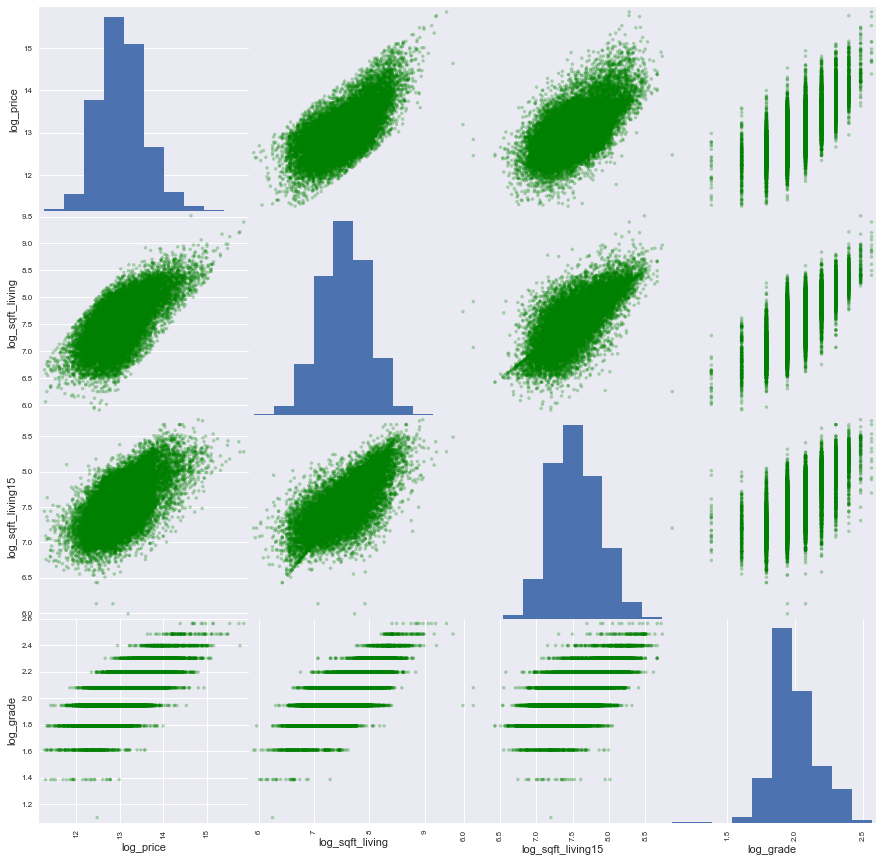

In [71]:
"""Let's see how the log_df looks as a scatter matrix."""
pd.plotting.scatter_matrix(log_df, figsize = (15,15), c = "green", alpha = 0.3)
plt.show()

In [72]:
log_df.corr().log_price

log_price            1.000000
log_sqft_living      0.674802
log_sqft_living15    0.607154
log_grade            0.693837
Name: log_price, dtype: float64

In [73]:
"""Now we add them to the dataframe"""
df = pd.concat((df, log_df), axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15,log_price,log_sqft_living,log_sqft_living15,log_grade
0,221900.0,3,1.00,1180,1.0,NaN,0.0,3,7,1955,0.0,98178,1340,12.309982,7.073270,7.200425,1.945910
1,538000.0,3,2.25,2570,2.0,0.0,0.0,3,7,1951,1991.0,98125,1690,13.195614,7.851661,7.432484,1.945910
2,180000.0,2,1.00,770,1.0,0.0,0.0,3,6,1933,NaN,98028,2720,12.100712,6.646391,7.908387,1.791759
3,604000.0,4,3.00,1960,1.0,0.0,0.0,5,7,1965,0.0,98136,1360,13.311329,7.580700,7.215240,1.945910
4,510000.0,3,2.00,1680,1.0,0.0,0.0,3,8,1987,0.0,98074,1800,13.142166,7.426549,7.495542,2.079442


In [74]:
"""Now we'll convert zipcode to category."""
zip_dummies = pd.get_dummies((df.zipcode), prefix='zip')

In [75]:
df = pd.concat((df, zip_dummies), axis=1)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 87 columns):
price                21597 non-null float64
bedrooms             21597 non-null int64
bathrooms            21597 non-null float64
sqft_living          21597 non-null int64
floors               21597 non-null float64
waterfront           19221 non-null float64
view                 21534 non-null float64
condition            21597 non-null int64
grade                21597 non-null int64
yr_built             21597 non-null int64
yr_renovated         17755 non-null float64
zipcode              21597 non-null int64
sqft_living15        21597 non-null int64
log_price            21597 non-null float64
log_sqft_living      21597 non-null float64
log_sqft_living15    21597 non-null float64
log_grade            21597 non-null float64
zip_98001            21597 non-null uint8
zip_98002            21597 non-null uint8
zip_98003            21597 non-null uint8
zip_98004            21597 non-

In [77]:
"""Finally, we'll partition the cleaned data set for our ultimate test."""
df, df_holdout = train_test_split(df, test_size=0.15) 

In [78]:
df_holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240 entries, 213 to 14789
Data columns (total 87 columns):
price                3240 non-null float64
bedrooms             3240 non-null int64
bathrooms            3240 non-null float64
sqft_living          3240 non-null int64
floors               3240 non-null float64
waterfront           2914 non-null float64
view                 3231 non-null float64
condition            3240 non-null int64
grade                3240 non-null int64
yr_built             3240 non-null int64
yr_renovated         2675 non-null float64
zipcode              3240 non-null int64
sqft_living15        3240 non-null int64
log_price            3240 non-null float64
log_sqft_living      3240 non-null float64
log_sqft_living15    3240 non-null float64
log_grade            3240 non-null float64
zip_98001            3240 non-null uint8
zip_98002            3240 non-null uint8
zip_98003            3240 non-null uint8
zip_98004            3240 non-null uint8
zip_98005

In [81]:
df_holdout.to_csv("df_holdout.csv")

In [82]:
df.to_csv("df_train.csv")